In [1]:
# Import model
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.externals import joblib

f = open("./svm_model/model.p", "rb")

disk_pickle = pickle.load( f )

X_scaler = pickle.load(open("./svm_model/X_scaler.pkl", "rb"))
svc = joblib.load("./svm_model/svm.pkl")

color_space = disk_pickle["color_space"]
orient = disk_pickle["orient"]
pix_per_cell = disk_pickle["pix_per_cell"]
cell_per_block = disk_pickle["cell_per_block"]
hog_channel = disk_pickle["hog_channel"]
spatial_size = disk_pickle["spatial_size"]
hist_bins = disk_pickle["hist_bins"]
spatial_feat = disk_pickle["spatial_feat"]
hist_feat = disk_pickle["hist_feat"]
hog_feat = disk_pickle["hog_feat"]


In [16]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label
from functions import *

pixel_last = [[], []]

def process_img(img):
    draw_img = np.copy(img)
    global pixel_last
    
    ystart = 400
    ystop = 656

    scales = [1.0, 1.4, 2.5]
    y_start_stop = [[380, 500], [400, 600], [500, 700]]    
        
    c=0
    bbox = []    
    bbox_color = []
    for scale in scales:
        y_ss = y_start_stop[c]
#         out_img, box_list, pred_dist = find_cars(img, y_ss[0], y_ss[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, is_pred_dist=True, threshold_pred=0.5)
        out_img, box_list, pred_dist = find_cars(img, y_ss[0], y_ss[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
                
        color = (0, 0, c*30 + 30)
        
        if len(box_list)>0:
            for b in box_list:
                bbox.append(b)                
                
            draw_img = draw_boxes(draw_img, box_list, (0, 0, (c+1)/8*255))
            
        c+=1

#      #######################################
#     # Filterfing
#     from scipy.ndimage.measurements import label
#     curMap = np.ones_like(img[:,:,0]).astype(np.float)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox)
    
    
    # Apply threshold to help remove false positives
    heatmap = np.copy(heat)
    heatmap_cur = np.copy(heat)
    
    nLastFrame = 0
    for frame in pixel_last:
        if len(frame) != 0:
            nLastFrame = nLastFrame + 1
            heatmap += frame
    
    heatmap = apply_threshold(heatmap, 3)
#     heatmap_std = heatmap.std(ddof=1)
#     if heatmap_std != 0.0:
#         heatmap = (heatmap-heatmap.mean())/heatmap_std
#     heatmap = apply_threshold(heatmap, np.max([heatmap.std(), 1]))

#     heatmap += label_pframe
    
#     curMap = heat
    
# #     heatmap[label_pframe<=2]=0
                              
    # Visualize the heatmap when displaying    
    heatmap_clip = np.clip(heatmap, 0, 255)    
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap_clip)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    ##########################################
    # Debuging window
    heatmap_sizeX = img.shape[1] // 3
    heatmap_sizeY = img.shape[0] // 3
    heatmap_resize = cv2.resize(heatmap, (heatmap_sizeX, heatmap_sizeY))
    
    heatmap_resize[heatmap_resize>0] = 255
    
    draw_img[0:ystart, :, :] = draw_img[0:ystart, :, :]*0.2
    draw_img[ystop:img.shape[0], :, :] = draw_img[ystop:img.shape[0], :, :]*0.2
    
    draw_img[0:heatmap_sizeY, 0:heatmap_sizeX, 0] = heatmap_resize
    draw_img[0:heatmap_sizeY, 0:heatmap_sizeX, 1] = 0
    draw_img[0:heatmap_sizeY, 0:heatmap_sizeX, 2] = 0
    
    pframe_resize = np.zeros_like(heatmap_resize)
    if ((len(pixel_last[0])!=0) and (len(pixel_last[1])!=0)):
        pframe_resize = pixel_last[0] + pixel_last[1]
    pframe_resize = cv2.resize(pframe_resize, (heatmap_sizeX, heatmap_sizeY))
    pframe_resize[pframe_resize<=1] = 0
    pframe_resize = pframe_resize * 60
    draw_img[0:heatmap_sizeY, 854:draw_img.shape[1], 0] = pframe_resize
    
    
    pixel_last[0] = heatmap_cur
    pixel_last[1] = pixel_last[1]
    
    return draw_img
    

In [ ]:


imag_list = []
image = mpimg.imread('../test_images/test1.jpg')
imag_list.append(image)
image = mpimg.imread('../test_images/test2.jpg')
imag_list.append(image)
image = mpimg.imread('../test_images/test3.jpg')
imag_list.append(image)
image = mpimg.imread('../test_images/test4.jpg')
imag_list.append(image)
image = mpimg.imread('../test_images/test5.jpg')
imag_list.append(image)
image = mpimg.imread('../test_images/test6.jpg')
imag_list.append(image)


ystart = 400
ystop = 656

out_img_list = []
heatmap_list = []
box_list_list = []

for img in imag_list:
    draw_img = process_img(img)
    out_img_list.append(draw_img)


In [ ]:
fig = plt.figure()
plt.subplot(221)
plt.imshow(out_img_list[0])
plt.subplot(222)
plt.imshow(out_img_list[3])
plt.subplot(223)
plt.imshow(out_img_list[4])
plt.subplot(224)
plt.imshow(out_img_list[5])


fig.tight_layout()
plt.show()


In [3]:
#######################################
## Test video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

output = 'result_vehicle_detection.mp4'

clip2 = VideoFileClip("../project_video.mp4")

# out_clip = clip2.fl_image( process_img )
# %time out_clip.write_videofile( output, audio=False)


C:\Users\Lim\Anaconda3\envs\udacity\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
C:\Users\Lim\Anaconda3\envs\udacity\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))


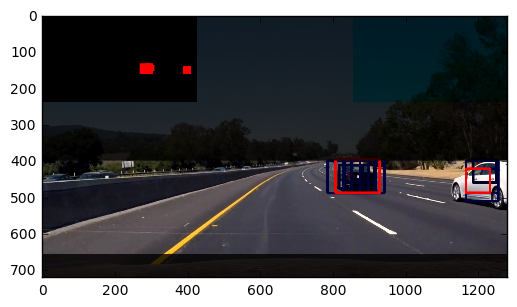

In [48]:
img = clip2.get_frame(44)

out = process_img(img)

fig = plt.figure()
plt.imshow(out)
plt.show()